In [1]:
from structs.fanworks import FicLibrary
from scrapers.ao3 import fic_fields, to_list, load_works
import pandas as pd
from encoder import make_multi_encoder, make_single_encoder
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
plt.style.use("gruvbox.mplstyle")
ofmd=FicLibrary.from_dataframe(load_works("Our Flag Means Death (TV)"))


## Popular Tags and Fic Popularity

In [18]:
ofmd["hits"]=ofmd["hits"].apply(lambda x: 0 if x=="" else float(x))
ofmd["kudos"]=ofmd["kudos"].apply(lambda x: 0 if x=="" else float(x))
ofmd["approval"]=ofmd["kudos"]/ofmd["hits"]

In [28]:
predictions = model.predict(X_test)
r2 = r2_score(y_test, predictions)
rmse = mean_squared_error(y_test, predictions, squared=False)

print('The r2 is: ', r2)
print('The rmse is: ', rmse)

The r2 is:  0.0702668295490384
The rmse is:  3806.5104632379603


In [ ]:
v=np.array(data["rating"])

In [ ]:
v.reshape(-1,1)

array([['Teen And Up Audiences'],
       ['Teen And Up Audiences'],
       ['General Audiences'],
       ...,
       ['General Audiences'],
       ['Teen And Up Audiences'],
       ['General Audiences']], dtype=object)

In [ ]:
a=OneHotEncoder()

In [ ]:
tf=a.fit_transform(v.reshape(-1,1))

In [ ]:
X=tf
y=ofmd["hits"]

X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=True, train_size=0.7)

In [ ]:
model.fit(X_train, y_train)

LinearRegression(fit_intercept=False)

In [ ]:
predictions = model.predict(X_test)
r2 = r2_score(y_test, predictions)
rmse = mean_squared_error(y_test, predictions, squared=False)

print('The r2 is: ', r2)
print('The rmse is: ', rmse)

The r2 is:  0.034556355840471786
The rmse is:  4089.7194169457507


In [53]:
ts={t:tags[t].value_counts()[1.0] for t in tags.columns}

In [54]:
f=pd.DataFrame.from_records([ {"tag": t[0], "count": t[1]} for t in ts.items()])

In [60]:
d=f.sort_values(by="count", ascending=False).to_dict(orient="records")

In [61]:
data["hits"]=data["hits"].map(lambda x: float(x) if x !="" else 0)
data["kudos"]=data["kudos"].map(lambda x: float(x) if x !="" else 0)


In [62]:
for rec in d:
    rec["avg_hits"]=data[data[rec["tag"]]==1.0]["hits"].sum()/rec["count"]
    rec["avg_kudos"]=data[data[rec["tag"]]==1.0]["kudos"].sum()/rec["count"]

In [65]:
avg_hits=data["hits"].sum()/len(data)
avg_kudos=data["kudos"].sum()/len(data)

In [66]:
tags=[a["tag"] for a in d]

In [40]:
angst=data[data["Angst"]==1.0]

In [71]:
t=[a["tag"] for a in d]
pop=[a['count'] for a in d]
hits=[a['avg_hits'] for a in d]

<BarContainer object of 665 artists>

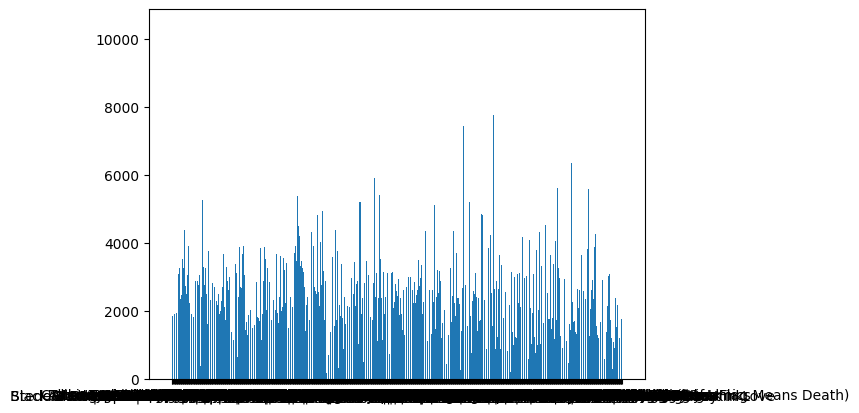

In [73]:
plt.bar(t, hits)

## The Big Model

In [2]:
example=ofmd.iloc[0]
example

title                                                   Lovely Letters
authors                                        [<User [kookaburrito]>]
categories                                                       [M/M]
rating                                           Teen And Up Audiences
warnings                                   [No Archive Warnings Apply]
relationships                 [Blackbeard | Edward Teach/Stede Bonnet]
tags                 [Canon Compliant, Alternate Canon, Letters, Lo...
id                                                            51314557
hits                                                                 4
kudos                                                                 
bookmarks                                                             
complete                                                          True
date_updated                                                2023-11-02
expected_chapters                                                  1.0
nchapt

In [20]:
def simple_model(fics, features, targets):
    for f in features:
        fics[f] = fics[f].apply(lambda x: 0 if x == "" else float(x))
    fics.fillna(value=0.0, inplace=True)
    fics.replace([np.inf, -np.inf], 0.0, inplace=True)
    model = LinearRegression()
    X = fics[targets]
    y = fics[features]
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, shuffle=True, train_size=0.7
    )
    model.fit(X_train, y_train)
    return model, X_test, y_test

def numberize(fics, column):
    return fics[column].apply(lambda x: 0 if x == "" else float(x))

In [21]:
fics=FicLibrary.from_dataframe(load_works("Our Flag Means Death (TV)"))
features=["kudos", "expected_chapters", "nchapters", "words", "comments"]
target=["hits"]

fics["hits"]=numberize(fics, "hits")
fics["hits"]=np.log(fics["hits"])

model, X_test, y_test=simple_model(fics, features, target)

/home/ehudson/projects/fanficStats/.venv/lib/python3.11/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


y_pred = model.predict(X_test)
rmse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
plt.hist(np.e**y_pred, bins=100, range=(0,200))
plt.hist(np.e**y_test, alpha=0.5, bins=100, range=(0,200))

## Troubleshooting

In [4]:
def make_numerical(data):
    numeric=["hits", "kudos", "bookmarks", "expected_chapters", "nchapters", "words", "comments"]
    for n in numeric:
        data[n]=data[n].map(lambda x: 0 if x=='' else int(float(x)))

In [4]:
def make_graphs(data):
    targets=[d for d in data.dtypes.to_dict().keys() if data.dtypes[d] == np.dtype("int64")]
    sets=[]
    for t in targets:
        for v in targets:
            rel=set([t, v])
            if (rel not in sets):
                plt.scatter(np.log(data[t]), np.log(data[v]))
                plt.xlabel(t)
                plt.ylabel(v)
                plt.xticks([])
                plt.yticks([])
                plt.savefig(f'./graphs/{t}_{v}')
                plt.show()
                sets.append(rel)
            


In [5]:
def make_log(fics, features):
    for feature in features:
        fics[feature+"_log"]=np.log2(fics[feature])
    fics.replace(to_replace=-np.inf, value=np.float64(-1), inplace=True)

In [6]:
model = LinearRegression()
features=["kudos", "hits", "bookmarks", "expected_chapters", "nchapters", "words", "comments"]
make_numerical(ofmd)
make_log(ofmd, features)


/home/el_hudson/projects/fanficStats/.venv/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/el_hudson/projects/fanficStats/.venv/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/el_hudson/projects/fanficStats/.venv/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/el_hudson/projects/fanficStats/.venv/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/el_hudson/projects/fanficStats/.venv/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufun

In [6]:
y=ofmd[["kudos_log"]]
X=ofmd[["hits", "hits_log", "comments", "comments_log", "nchapters", "nchapters_log"]]
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=True, train_size=0.7)
model.fit(X_train, y_train)

LinearRegression()

y=kudos
x=hits
m=coefficient
b=intercept (where X is 0, y is...)

In [7]:
sum(ofmd["kudos_log"])/sum(ofmd["hits_log"])

0.6615669973644743

In [13]:
print(model.coef_, model.intercept_)

[[-8.41962739e-07  8.48837131e-01 -5.80294850e-04  2.44475181e-01
   4.27089506e-03 -4.31387629e-01]] [-2.28326191]


In [46]:
y_pred=model.predict(X_test)
y_pred_df=pd.DataFrame(columns=["approval_log"], data=y_pred)
y_test_df=pd.DataFrame(columns=["approval_log"], data=y_test)
r2=r2_score(y_test, y_pred)
rmse=mean_squared_error(y_test, y_pred)
print(f'RMSE: {rmse} \n R2: {r2}')


RMSE: 0.014915703802721314 
 R2: 0.15896826677981102


In [10]:

def get_values(samples, attr):
    s = []
    for d in samples[attr]:
        s.extend(d)
    tags = {t: s.count(t) for t in list(set(s))}
    counts = pd.DataFrame({attr: tags.keys(), "occurrences": tags.values()})
    if len(counts) > 500:
        return counts.loc[
            counts["occurrences"] >= np.percentile(counts["occurrences"], 99)
        ][attr].values.tolist()
    else:
        return counts[attr].values.tolist()

def make_multi_encoder(fics, feature):
    values=get_values(fics,feature)
    encoder=np.zeros((len(fics), len(values)))
    for fic in range(len(encoder)):
        for attr in range(len(values)):
            if values[attr] in fics.iloc[fic][feature]:
                encoder[fic][attr]=1.0
    df=pd.DataFrame(data=encoder, columns=values)
    return df



In [124]:
tags=pd.read_csv("data/encoders/our_flag_means_death_(tv).tsv", sep="\t")
ratings=make_single_encoder(ofmd, "rating")
warnings=make_multi_encoder(ofmd, "warnings")

In [18]:
warnings["Creator Chose Not To Use Archive Warnings"]

0        0.0
1        0.0
2        0.0
3        0.0
4        1.0
        ... 
24685    0.0
24686    1.0
24687    0.0
24688    0.0
24689    0.0
Name: Creator Chose Not To Use Archive Warnings, Length: 24690, dtype: float64

In [20]:
with_encoders=ofmd.join(tags).join(ratings).join(warnings)
with_encoders['approval_log']=ofmd["kudos_log"]/ofmd["hits_log"]

In [33]:
y=with_encoders[["approval_log"]]
feats=tags.columns.tolist()+ratings.columns.tolist()+warnings.columns.tolist()+["nchapters_log", "words_log"]
X=with_encoders[feats]
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=True, train_size=0.7)
model.fit(X_train, y_train)

LinearRegression()

In [34]:
y_pred=model.predict(X_test)
y_pred_df=pd.DataFrame(columns=["approval_log"], data=y_pred)
y_test_df=pd.DataFrame(columns=["approval_log"], data=y_test)
r2=r2_score(y_test, y_pred)
rmse=mean_squared_error(y_test, y_pred)
print(f'RMSE: {rmse} \n R2: {r2}')

RMSE: 0.014068844080416603 
 R2: 0.19467282606041936


(array([  1.,   1.,   1.,   2.,   7.,   0.,   5.,   4.,   1.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,  28.,   0.,   0.,   0.,   0.,
          0.,   0.,   1.,   7.,  12.,  10.,  10.,  13.,   5.,  11.,  13.,
         11.,  16.,  21.,  17.,  19.,  16.,  18.,  21.,  33.,  40.,  36.,
         45.,  56.,  45.,  57.,  63.,  60.,  83.,  74.,  99.,  97., 113.,
        130., 142., 166., 186., 194., 205., 238., 227., 291., 305., 295.,
        311., 319., 361., 354., 384., 398., 287., 281., 277., 221., 206.,
        160., 115.,  80.,  43.,  35.,  18.,   3.,   1.,   1.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          1.]),
 array([0.79370053, 0.80576352, 0.81782652, 0.82988951, 0.8419525 ,
        0.8540155 , 0.86607849, 0.87814149, 0.89020448, 0.90226748,
        0.91433047, 0.92639347, 0.93845646, 0.95051946, 0.96258245,
        0.97464545, 0.98670844, 0.99877144, 1.01083443, 1.02289743,
        1.03496042, 1.04702342, 1.05908641, 1.

findfont: Generic family 'serif' not found because none of the following families were found: IBM Plex Serif
findfont: Generic family 'serif' not found because none of the following families were found: IBM Plex Serif
findfont: Generic family 'serif' not found because none of the following families were found: IBM Plex Serif
findfont: Generic family 'serif' not found because none of the following families were found: IBM Plex Serif
findfont: Generic family 'serif' not found because none of the following families were found: IBM Plex Serif
findfont: Generic family 'serif' not found because none of the following families were found: IBM Plex Serif
findfont: Generic family 'serif' not found because none of the following families were found: IBM Plex Serif
findfont: Generic family 'serif' not found because none of the following families were found: IBM Plex Serif
findfont: Generic family 'serif' not found because none of the following families were found: IBM Plex Serif
findfont: Generic f

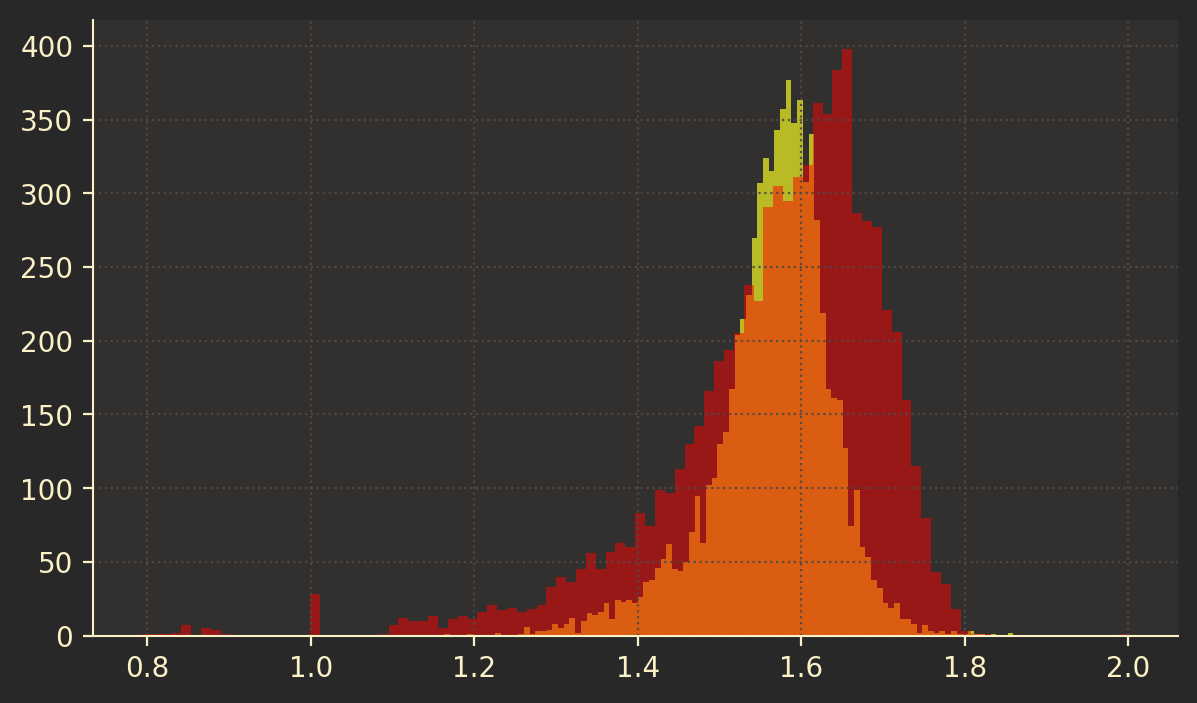

In [35]:
plt.hist(2**y_pred_df['approval_log'], bins=100)
plt.hist(2**y_test_df['approval_log'], bins=100, color="red", alpha=0.5)

In [36]:
model.coef_

array([[-5.26701397e-03,  1.25293267e-02,  1.44454631e-02,
        -4.36659283e-04,  1.38291233e-03, -5.67411089e-03,
        -2.06302851e-02,  1.89660864e-02, -2.84019647e-02,
        -9.78777906e-03,  5.70574834e-03, -8.88353370e-03,
        -3.92628011e-02, -5.16779116e-03, -1.65361982e-02,
         1.07232456e-02,  1.93781830e-02,  2.15176762e-02,
         2.24837804e-03, -3.78806118e-02,  1.25073683e-02,
        -7.00094993e-03, -1.94137490e-02,  1.86379784e-02,
         1.77825756e-02,  4.74691830e-03,  1.18031348e-02,
        -6.85900858e-03,  3.66820054e-02,  1.36685924e-03,
         4.00167003e-03,  2.27936003e-03,  1.71811648e-02,
        -1.34844241e-02,  3.27714839e-02,  2.19045759e-02,
        -1.51880319e-02, -7.93677161e-03, -9.91722599e-03,
        -8.42816350e-03,  8.00034453e-03,  8.02965592e-03,
         1.45771665e-02,  1.51668786e-02, -5.21058992e-03,
         1.42391892e-02, -3.43959056e-04, -5.34798819e-03,
         4.62263434e-03,  1.81481034e-02,  1.22471981e-0

In [113]:
l=zip(feats, model.coef_[0])

In [116]:
v=list(l)
v.sort(key=lambda x: x[1])

In [125]:
tags_weights=[a for a in v if a[0] in tags.columns]
ratings_weights=[a for a in v if a[0] in ratings.columns]
warnings_weights=[a for a in v if a[0] in warnings.columns]

In [127]:
ratings_weights

[('Not Rated', -0.027174837277010793),
 ('General Audiences', -0.0051105417248735255),
 ('Mature', 0.006689621847104317),
 ('Teen And Up Audiences', 0.009002079273263732),
 ('Explicit', 0.01659367788151616)]

In [128]:
warnings_weights

[('Underage', -0.03487983233710556),
 ('Major Character Death', -0.030488137669416465),
 ('Graphic Depictions Of Violence', -0.027772395576947044),
 ('Rape/Non-Con', -0.01588448405682925),
 ('Creator Chose Not To Use Archive Warnings', -0.009435609084702888),
 ('No Archive Warnings Apply', 0.018076190818477497)]

In [129]:
tags_weights

[('Songfic', -0.13360312334128885),
 ('Poetry', -0.10668753823144682),
 ('Meta', -0.09353372889054261),
 ('Podfic', -0.08337884559164417),
 ('Original Character(s)', -0.08294153840396694),
 ('Crossover', -0.07393126836668114),
 ('Female Stede Bonnet', -0.07082539878699079),
 ('Podfic Length: 0-10 Minutes', -0.07045527297433161),
 ('Our Flag Means Death Kinktober 2023', -0.069781634797972),
 ('Podfic Length: 10-20 Minutes', -0.06857715285708606),
 ('Drama', -0.063936645389667),
 ('Gay Sex', -0.05770428303998185),
 ('Sad', -0.056837851191052405),
 ("I'm Bad At Tagging", -0.05589863076412654),
 ('Christmas', -0.05412819363287969),
 ('Podfic & Podficced Works', -0.05208370148810128),
 ('Other Additional Tags to Be Added', -0.05194053375187116),
 ('Cute', -0.05191887098304979),
 ('Fancyfuck', -0.05059666326043001),
 ('gentlebeard', -0.04965841945119179),
 ('Young Blackbeard | Edward Teach', -0.04922927814173406),
 ('Drabble', -0.048951947528678756),
 ('Hallucinations', -0.047174340792270196

## Ratings and Warnings

In [44]:
ratings=ofmd["rating"]

In [55]:
def make_single_encoder(fics, feature):
    samples=fics[feature]
    vals=list(set(samples.values))
    enc=np.zeros((len(samples), len(vals)))
    for f in range(len(fics)):
        for v in range(len(vals)): 
            if fics.iloc[f][feature]==vals[v]:
                enc[f][v]=1.0
    df=pd.DataFrame(data=enc, columns=vals)
    return df
    

In [46]:
vals=list(set(ratings.values))
ratings_enc=np.zeros((len(ratings), len(vals)))

In [41]:
vals

['Mature',
 'Teen And Up Audiences',
 'Not Rated',
 'General Audiences',
 'Explicit']

In [47]:
for f in range(len(ofmd)):
    for v in range(len(vals)): 
        if ofmd.iloc[f]['rating']==vals[v]:
            ratings_enc[f][v]=1.0
    

In [49]:
fr=pd.DataFrame(data=ratings_enc, columns=vals)

In [50]:
fr

,Mature,Teen And Up Audiences,Not Rated,General Audiences,Explicit
0,0.0,1.0,0.0,0.0,0.0
1,0.0,1.0,0.0,0.0,0.0
2,0.0,0.0,0.0,1.0,0.0
3,0.0,1.0,0.0,0.0,0.0
4,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...
24685,0.0,1.0,0.0,0.0,0.0
24686,0.0,1.0,0.0,0.0,0.0
24687,0.0,0.0,0.0,1.0,0.0
24688,0.0,1.0,0.0,0.0,0.0


In [51]:
with_ratings=ofmd.join(fr)

In [52]:
with_ratings

,title,authors,categories,rating,warnings,relationships,tags,id,hits,kudos,...,series,summary,fandoms,words,comments,Mature,Teen And Up Audiences,Not Rated,General Audiences,Explicit
0,Lovely Letters,[<User [kookaburrito]>],[M/M],Teen And Up Audiences,[No Archive Warnings Apply],[Blackbeard | Edward Teach/Stede Bonnet],"[Canon Compliant, Alternate Canon, Letters, Lo...",51314557,4,,...,[],\nSlightly canon divergent / canon filler AUEd...,[Our Flag Means Death (TV)],5383.0,,0.0,1.0,0.0,0.0,0.0
1,A Pirate's Life For Us,[<User [Regent_of_RarePairs]>],[M/M],Teen And Up Audiences,[Graphic Depictions Of Violence],[Fang/Ivan (Our Flag Means Death)],"[season 2 re-write, Alternate Universe - Canon...",51314440,0,,...,[],\nWhat started when Bonnet left Ed on the dock...,[Our Flag Means Death (TV)],379.0,,0.0,1.0,0.0,0.0,0.0
2,Slow match,[<User [aloc]>],[Gen],General Audiences,[No Archive Warnings Apply],[],[],51314290,15,2.0,...,[],\nIllustration\n,[Our Flag Means Death (TV)],0.0,,0.0,0.0,0.0,1.0,0.0
3,A Good Pirate's Tale,[<User [tikli]>],[Gen],Teen And Up Audiences,[No Archive Warnings Apply],[Blackbeard | Edward Teach/Stede Bonnet],"[Fix-It, Episode Fix-it, Alternate Universe - ...",51314122,56,12.0,...,[],"\n“It’s only suicide if we die,” Bonnet chirpe...",[Our Flag Means Death (TV)],1253.0,3.0,0.0,1.0,0.0,0.0,0.0
4,The Captains' Christmas Calendar,[<User [GreenQuilll]>],"[Gen, M/M]",Not Rated,[Creator Chose Not To Use Archive Warnings],"[Blackbeard | Edward Teach/Stede Bonnet, Black...","[Drabble, Advent Calendar, Advent Calendar Dra...",51313786,13,1.0,...,[],"\nAs a pirate on the high seas, there are many...",[Our Flag Means Death (TV)],14.0,,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24685,sorry he is to be hanged,[<User [zenith (DallonR)]>],[M/M],Teen And Up Audiences,[No Archive Warnings Apply],"[Stede Bonnet/Blackbeard, Blackbonnet, Blackst...","[Spoilers, Pirates, Historical Figures, Golden...",37643530,3328,407,...,[<Series [seize my soul]>],"\nEdward Teach, also known as Blackbeard, know...",[Our Flag Means Death (TV)],3232,92.0,0.0,1.0,0.0,0.0,0.0
24686,Castaways,[<User [caterpillar_rave]>],"[M/M, Other]",Teen And Up Audiences,[Creator Chose Not To Use Archive Warnings],"[Stede Bonnet/Blackbeard, Blackbonnet, Oluwand...","[Whump, Hurt/Comfort, Not Too Graphic Depictio...",37620700,3760,280,...,[],\nStede Bonnet awakes in the dark…\n,[Our Flag Means Death],1845,13.0,0.0,1.0,0.0,0.0,0.0
24687,From the Far Reaches of the Seven Seas,[<User [WackyPegasus]>],[Gen],General Audiences,[No Archive Warnings Apply],[],"[dancer cyrus (secondary job), pirates!]",36647434,98,4,...,[],\nIn the hopes of finding information on From ...,"[Octopath Traveler (Video Game), Our Flag Mean...",3469,,0.0,0.0,0.0,1.0,0.0
24688,By the Bi,[<User [emilycare]>],[M/M],Teen And Up Audiences,[No Archive Warnings Apply],"[Sherlock Holmes/John Watson, Johnlock, Sherlo...","[Anniversary, Fluff, Love Confessions, Bisexua...",29079627,5330,496,...,[],\nIt's been a year of living together. Sherloc...,"[Sherlock Holmes & Related Fandoms, Sherlock (...",9821,80.0,0.0,1.0,0.0,0.0,0.0
